#### **Keyword Extraction from Titles and Abstracts of Academic papers**

In [1]:
!pip install rake-nltk yake keybert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
import time
import re

In [5]:
model_time = {}

## Data Preprocessing

In [6]:
import pandas as pd
import ast

df = pd.read_csv('pubmed_papers_1193.csv', converters={'author_keywords': ast.literal_eval})

In [7]:
df.head()

,title,abstract,author_keywords
0,Exercise and other non-pharmaceutical interven...,To assess the relative effects of different ty...,"[cancer related fatigue, exercise, indirect co..."
1,Effectiveness of conservative interventions in...,To investigate the effectiveness of conservati...,"[Conservative, MetaAnalysis, Pain, Shoulder Im..."
2,Effectiveness of myopia control interventions:...,This study aims to investigate the effectivene...,"[axial length, efficacy, elongation, myopia, p..."
3,Causal relationships between gut microbiota an...,Multiple clinical studies have indicated that ...,"[PD1PDL1, bidirectional Mendelian randomizatio..."
4,Prevention of hypotension after spinal anaesth...,Spinal anaesthesia for caesarean section commo...,"[anaesthesia, spinal, caesarean section, hypot..."


In [8]:
df.columns

Index(['title', 'abstract', 'author_keywords'], dtype='object')

In [9]:
df.shape

(1193, 3)

In [10]:
df.dtypes

title              object
abstract           object
author_keywords    object
dtype: object

In [11]:
df.isnull().sum()

title              0
abstract           0
author_keywords    0
dtype: int64

In [12]:
print(type(df.loc[5, 'author_keywords']))
print(df.loc[5, 'author_keywords'])

<class 'list'>
['acceptability', 'allergic rhinitis', 'efficacy', 'intranasal corticosteroid', 'metaanalysis', 'systematic review', 'total nasal symptom score', 'total ocular symptom score']


In [13]:
#df['author_keywords'] = df['author_keywords'].apply(lambda x: [keyword.strip() for keyword in x.split(',')])
df['title_with_abstract'] = df['title'] + df['abstract']

In [14]:
df.loc[1, 'title_with_abstract']

'Effectiveness of conservative interventions including exercise, manual therapy and medical management in adults with shoulder impingement: a systematic review and meta-analysis of RCTs.To investigate the effectiveness of conservative interventions for pain, function and range of motion in adults with shoulder impingement.Systematic review and meta-analysis of randomised trials.Medline, CENTRAL, CINAHL, Embase and PEDro were searched from inception to January 2017.Randomised controlled trials including participants with shoulder impingement and evaluating at least one conservative intervention against sham or other treatments.For pain, exercise was superior to non-exercise control interventions (standardised mean difference (SMD) -0.94, 95%\u2009CI -1.69 to -0.19). Specific exercises were superior to generic exercises (SMD -0.65, 95%\u2009CI -0.99 to -0.32). Corticosteroid injections were superior to no treatment (SMD -0.65, 95%\u2009CI -1.04 to -0.26), and ultrasound guided injections

In [15]:
df['title_with_abstract'] = df['title_with_abstract'].apply(lambda x: x.replace('\n', ' '))

We clean the text by removing whitespaces, punctuations, links and text with square brackets or parantheses

In [16]:
def preprocess_text(text):
  text = re.sub(r'http\S+', ' ', text)
  text = re.sub(r'[^\w\s]', ' ', text)
  text = re.sub(r'\([^)]*\)', ' ', text)
  text = re.sub(r'\[[^]]*\]', ' ', text)
  text = re.sub(r'\s+', ' ', text).strip().lower()
  return text

df['title_with_abstract'] = df['title_with_abstract'].apply(preprocess_text)


In [17]:
df.loc[23, 'title_with_abstract']

'new evidence for the effect of type 2 diabetes and glycemic traits on testosterone levels a two sample mendelian randomization study type 2 diabetes mellitus t2dm is an endocrine related disease with an increasing incidence worldwide male sexual dysfunction is common in diabetic patients therefore we designed a mendelian randomization mr study to investigate the association of type 2 diabetes and 3 glycemic traits with testosterone levels uncorrelated single nucleotide polymorphisms snps associated with t2dm n 228 fasting insulin n 38 fasting glucose n 71 and hba1c n 75 at the genome wide significance were selected as instrument variables genetic associations with testosterone levels total testosterone tt bioavailable testosterone bt and sex hormone binding globulin shbg were obtained from the uk biobank studies and other large consortia two sample mr analysis was used to minimize the bias caused by confounding factors and response causality multivariable mr analysis was performed usi

## TF-IDF

In [18]:
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from operator import itemgetter
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

class TFIDFKeywordExtractor:
    def __init__(self):
        self.cv = CountVectorizer(max_df=0.85, stop_words=stopwords.words('english'), ngram_range=(1, 2)) #considering unigrams and bigrams, ignore terms occuring in more than 85% docs
        self.tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
        self.feature_names = None

    def preprocess_and_tokenize(self, text):
        '''
        lemmatize, tag and extract words with required pos tags
        '''
        lemmatizer = WordNetLemmatizer()
        tokenized_text = word_tokenize(text)
        pos_tags = pos_tag(tokenized_text)
        lemmatized_text = []
        for word, tag in pos_tags:
            if tag in ['JJ', 'JJR', 'JJS']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='a')) #so that comparative and superlative forms are lemmatized
            else:
                lemmatized_text.append(lemmatizer.lemmatize(word))
        pos_tags_lemmatized = pos_tag(lemmatized_text)
        wanted_POS = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VBG', 'FW']
        processed_text = [word for word, tag in pos_tags_lemmatized if tag in wanted_POS]
        return ' '.join(processed_text)

    def fit_transform(self, documents):
        preprocessed_documents = [self.preprocess_and_tokenize(doc) for doc in documents]
        word_count_vector = self.cv.fit_transform(preprocessed_documents)
        self.feature_names = self.cv.get_feature_names_out()
        tfidf_vector = self.tfidf_transformer.fit_transform(word_count_vector)
        return tfidf_vector

    def sort_coo(self, coo_matrix):
        '''
        keywords with higher tf idf score appear first
        '''
        tuples = zip(coo_matrix.col, coo_matrix.data)
        return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

    def extract_topn_from_vector(self, sorted_items, topn):
        '''
        extract required number of keywords
        '''
        sorted_items = sorted_items[:topn]
        results = {}
        for idx, score in sorted_items:
            results[self.feature_names[idx]] = round(score, 3)
        return results

    def get_keywords(self, idx, topn=5):
        tf_idf_vector = self.tfidf_transformer.transform(self.cv.transform([docs[idx]]))
        sorted_items = self.sort_coo(tf_idf_vector.tocoo())
        keywords_with_scores = self.extract_topn_from_vector(sorted_items, topn)
        return list(keywords_with_scores.keys())

In [19]:
tf_start_time = time.time()

docs = df['title_with_abstract'].tolist()

keyword_extractor = TFIDFKeywordExtractor()
tfidf_vector = keyword_extractor.fit_transform(docs)

results = [keyword_extractor.get_keywords(i) for i in range(tfidf_vector.shape[0])]

tf_end_time = time.time()
tf_elapsed_time = tf_end_time - tf_start_time

model_time['TF-IDF'] = f'{tf_elapsed_time:.4f}'

df['tf_idf_keywords'] = results

In [20]:
df.head()

,title,abstract,author_keywords,title_with_abstract,tf_idf_keywords
0,Exercise and other non-pharmaceutical interven...,To assess the relative effects of different ty...,"[cancer related fatigue, exercise, indirect co...",exercise and other non pharmaceutical interven...,"[non pharmaceutical, exercise non, cancer trea..."
1,Effectiveness of conservative interventions in...,To investigate the effectiveness of conservati...,"[Conservative, MetaAnalysis, Pain, Shoulder Im...",effectiveness of conservative interventions in...,"[superior, shoulder impingement, manual therap..."
2,Effectiveness of myopia control interventions:...,This study aims to investigate the effectivene...,"[axial length, efficacy, elongation, myopia, p...",effectiveness of myopia control interventions ...,"[mm, atropine, myopia, dose atropine, ci]"
3,Causal relationships between gut microbiota an...,Multiple clinical studies have indicated that ...,"[PD1PDL1, bidirectional Mendelian randomizatio...",causal relationships between gut microbiota an...,"[βivw, sub fdr, fdr, sub, pd]"
4,Prevention of hypotension after spinal anaesth...,Spinal anaesthesia for caesarean section commo...,"[anaesthesia, spinal, caesarean section, hypot...",prevention of hypotension after spinal anaesth...,"[anaesthesia, hypotension, spinal anaesthesia,..."


In [21]:
print(type(df.loc[5, 'tf_idf_keywords']))
print(df.loc[5, 'tf_idf_keywords'][0])

<class 'list'>
ar


## KeyBert

In [22]:
from keybert import KeyBERT

'''
Tokenize text into candidate keywords
generate embeddings for the candidates as well as the doc
compute cosine similarity of candidates with the doc
'''

# initialize KeyBERT model
kw_model = KeyBERT()

# extract keywords using KeyBERT model
def extract_keybert_keywords(text):
    keybert_start_time = time.time()

    keywords_with_scores = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), top_n=5)
    keywords = [keyword[0] for keyword in keywords_with_scores]

    keybert_end_time = time.time()
    keybert_elapsed_time = keybert_end_time - keybert_start_time

    model_time['KeyBert'] = f'{keybert_elapsed_time:.4f}'

    return keywords

df['keybert_keywords'] = df['title_with_abstract'].apply(extract_keybert_keywords)

df.head()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,title,abstract,author_keywords,title_with_abstract,tf_idf_keywords,keybert_keywords
0,Exercise and other non-pharmaceutical interven...,To assess the relative effects of different ty...,"[cancer related fatigue, exercise, indirect co...",exercise and other non pharmaceutical interven...,"[non pharmaceutical, exercise non, cancer trea...","[treatment yoga, interventions cancer, yoga, f..."
1,Effectiveness of conservative interventions in...,To investigate the effectiveness of conservati...,"[Conservative, MetaAnalysis, Pain, Shoulder Im...",effectiveness of conservative interventions in...,"[superior, shoulder impingement, manual therap...","[shoulder impingement, patients shoulder, inte..."
2,Effectiveness of myopia control interventions:...,This study aims to investigate the effectivene...,"[axial length, efficacy, elongation, myopia, p...",effectiveness of myopia control interventions ...,"[mm, atropine, myopia, dose atropine, ci]","[effectiveness myopia, control myopia, myopia ..."
3,Causal relationships between gut microbiota an...,Multiple clinical studies have indicated that ...,"[PD1PDL1, bidirectional Mendelian randomizatio...",causal relationships between gut microbiota an...,"[βivw, sub fdr, fdr, sub, pd]","[microbiota pd, gut microbiota, immune checkpo..."
4,Prevention of hypotension after spinal anaesth...,Spinal anaesthesia for caesarean section commo...,"[anaesthesia, spinal, caesarean section, hypot...",prevention of hypotension after spinal anaesth...,"[anaesthesia, hypotension, spinal anaesthesia,...","[hypotension caesarean, anaesthesia caesarean,..."


In [23]:
print(type(df.loc[5, 'keybert_keywords']))
print(df.loc[5, 'keybert_keywords'])

<class 'list'>
['allergic rhinitis', 'rhinitis systematic', 'rhinitis reviewers', 'nasal symptom', 'intranasal corticosteroids']


## RAKE

In [24]:
from rake_nltk import Rake

'''
generate candidate keywords
compute co-occurence matrix for candidate keywords
generate a score for each keyword i -> sum(co-occ row[i])/diag[i]
'''

stop_words = list(set(nltk.corpus.stopwords.words('english')))

r = Rake(min_length=1, max_length=2, stopwords = stop_words)

def extract_rake_keywords(text):
    r_start_time = time.time()

    r.extract_keywords_from_text(text)
    keywords_with_scores = r.get_ranked_phrases_with_scores()[:5]
    keywords = [keyword[1] for keyword in keywords_with_scores]

    r_end_time = time.time()
    r_elapsed_time = r_end_time - r_start_time

    model_time['RAKE'] = f'{r_elapsed_time:.4f}'

    return keywords

df['rake_keywords'] = df['title_with_abstract'].apply(extract_rake_keywords)

df.head()

,title,abstract,author_keywords,title_with_abstract,tf_idf_keywords,keybert_keywords,rake_keywords
0,Exercise and other non-pharmaceutical interven...,To assess the relative effects of different ty...,"[cancer related fatigue, exercise, indirect co...",exercise and other non pharmaceutical interven...,"[non pharmaceutical, exercise non, cancer trea...","[treatment yoga, interventions cancer, yoga, f...","[usual care, treatment risk, relative effects,..."
1,Effectiveness of conservative interventions in...,To investigate the effectiveness of conservati...,"[Conservative, MetaAnalysis, Pain, Shoulder Im...",effectiveness of conservative interventions in...,"[superior, shoulder impingement, manual therap...","[shoulder impingement, patients shoulder, inte...","[systematic review, shoulder impingement, shou..."
2,Effectiveness of myopia control interventions:...,This study aims to investigate the effectivene...,"[axial length, efficacy, elongation, myopia, p...",effectiveness of myopia control interventions ...,"[mm, atropine, myopia, dose atropine, ci]","[effectiveness myopia, control myopia, myopia ...","[systematic review, systematic review, study a..."
3,Causal relationships between gut microbiota an...,Multiple clinical studies have indicated that ...,"[PD1PDL1, bidirectional Mendelian randomizatio...",causal relationships between gut microbiota an...,"[βivw, sub fdr, fdr, sub, pd]","[microbiota pd, gut microbiota, immune checkpo...","[study aimed, positively correlated, positive ..."
4,Prevention of hypotension after spinal anaesth...,Spinal anaesthesia for caesarean section commo...,"[anaesthesia, spinal, caesarean section, hypot...",prevention of hypotension after spinal anaesth...,"[anaesthesia, hypotension, spinal anaesthesia,...","[hypotension caesarean, anaesthesia caesarean,...","[systematic review, systematic review, spinal ..."


In [25]:
print(type(df.loc[5, 'rake_keywords']))
print(df.loc[5, 'rake_keywords'])

<class 'list'>
['systematic reviews', 'systematic review', 'study dropout', 'severe ar', 'primary outcomes']


## YAKE

In [26]:
import yake

'''
preprocess text, extract features using context, position, freq
assign score based on feature
consider uni, bi and trigrams and compute final scores for candidate keywords
deduplication using Levenshtein distance
'''

y = yake.KeywordExtractor(n=2, dedupLim=0.9, top=5, windowsSize=2, stopwords = stop_words)

def extract_yake_keywords(text):
    y_start_time = time.time()

    keywords_with_scores = y.extract_keywords(text)
    keywords = [keyword[0] for keyword in keywords_with_scores]

    y_end_time = time.time()
    y_elapsed_time = y_end_time - y_start_time

    model_time['YAKE'] = f'{y_elapsed_time:.4f}'

    return keywords

df['yake_keywords'] = df['title_with_abstract'].apply(extract_yake_keywords)

df.head()

,title,abstract,author_keywords,title_with_abstract,tf_idf_keywords,keybert_keywords,rake_keywords,yake_keywords
0,Exercise and other non-pharmaceutical interven...,To assess the relative effects of different ty...,"[cancer related fatigue, exercise, indirect co...",exercise and other non pharmaceutical interven...,"[non pharmaceutical, exercise non, cancer trea...","[treatment yoga, interventions cancer, yoga, f...","[usual care, treatment risk, relative effects,...","[resistance training, cancer treatment, pharma..."
1,Effectiveness of conservative interventions in...,To investigate the effectiveness of conservati...,"[Conservative, MetaAnalysis, Pain, Shoulder Im...",effectiveness of conservative interventions in...,"[superior, shoulder impingement, manual therap...","[shoulder impingement, patients shoulder, inte...","[systematic review, shoulder impingement, shou...","[shoulder impingement, manual therapy, exercis..."
2,Effectiveness of myopia control interventions:...,This study aims to investigate the effectivene...,"[axial length, efficacy, elongation, myopia, p...",effectiveness of myopia control interventions ...,"[mm, atropine, myopia, dose atropine, ci]","[effectiveness myopia, control myopia, myopia ...","[systematic review, systematic review, study a...","[dose atropine, myopia progression, low dose, ..."
3,Causal relationships between gut microbiota an...,Multiple clinical studies have indicated that ...,"[PD1PDL1, bidirectional Mendelian randomizatio...",causal relationships between gut microbiota an...,"[βivw, sub fdr, fdr, sub, pd]","[microbiota pd, gut microbiota, immune checkpo...","[study aimed, positively correlated, positive ...","[sub fdr, fdr sub, sub, causal relationship, g..."
4,Prevention of hypotension after spinal anaesth...,Spinal anaesthesia for caesarean section commo...,"[anaesthesia, spinal, caesarean section, hypot...",prevention of hypotension after spinal anaesth...,"[anaesthesia, hypotension, spinal anaesthesia,...","[hypotension caesarean, anaesthesia caesarean,...","[systematic review, systematic review, spinal ...","[spinal anaesthesia, caesarean section, preven..."


In [27]:
print(type(df.loc[5, 'yake_keywords']))
print(df.loc[5, 'yake_keywords'])

<class 'list'>
['severe allergic', 'allergic rhinitis', 'meta analysis', 'treating moderate', 'moderate quality']


## TextRank

In [28]:
import nltk
from nltk import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
import numpy as np
import math
import heapq
from operator import itemgetter

class TextRank:
    def __init__(self, text):
        self.text = text
        self.cleaned_text = self.clean_text()
        self.tokenized_text = word_tokenize(self.cleaned_text)
        self.POS_tag = self.get_POS_tags()
        self.lemmatized_text = self.lemmatize_text()
        self.stopwords_plus = self.get_stopwords()
        self.processed_text = self.process_text()
        self.vocabulary = list(set(self.processed_text))
        self.weighted_edge = self.build_weighted_edge()
        self.score = self.calculate_scores()
        self.keywords = self.extract_keywords()

    def clean_text(self):
        text = self.text.lower().strip()
        printable = set(string.printable)
        text = filter(lambda x: x in printable, text)
        return "".join(list(text))

    def get_POS_tags(self):
        return nltk.pos_tag(self.tokenized_text)

    def lemmatize_text(self):
        wordnet_lemmatizer = WordNetLemmatizer()
        adjective_tags = ['JJ', 'JJR', 'JJS']
        lemmatized_text = []
        for word in self.POS_tag:
            if word[1] in adjective_tags:
                lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(word[0], pos="a")))
            else:
                lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(word[0])))
        return lemmatized_text

    def get_stopwords(self):
        stopwords = []
        wanted_POS = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VBG', 'FW']
        for word in self.POS_tag:
            if word[1] not in wanted_POS:
                stopwords.append(word[0])
        punctuations = list(str(string.punctuation))
        stopwords = stopwords + punctuations
        return stopwords + list(set(nltk.corpus.stopwords.words('english')))

    def process_text(self):
        processed_text = []
        for word in self.lemmatized_text:
            if word not in self.stopwords_plus:
                processed_text.append(word)
        return processed_text

    def build_weighted_edge(self):
        '''
        graph with |V| vertices
        undirected weighted edges are drawn between vertices co-occuring within window
        self connections not allowed
        '''
        vocab_len = len(self.vocabulary)
        weighted_edge = np.zeros((vocab_len, vocab_len), dtype=np.float32)
        window_size = 3 #consider till trigrams
        covered_coocurrences = []
        for i in range(0, vocab_len):
            for j in range(0, vocab_len):
                if j != i:
                    for window_start in range(0, (len(self.processed_text) - window_size)):
                        window_end = window_start + window_size
                        window = self.processed_text[window_start:window_end]
                        if (self.vocabulary[i] in window) and (self.vocabulary[j] in window):
                            index_of_i = window_start + window.index(self.vocabulary[i])
                            index_of_j = window_start + window.index(self.vocabulary[j])

                            # two words co-occuring in the same location are not counted repetitively
                            if [index_of_i, index_of_j] not in covered_coocurrences:
                                weighted_edge[i][j] += 1 / math.fabs(index_of_i - index_of_j) # increase edge weight when two words co-occur in different positions
                                covered_coocurrences.append([index_of_i, index_of_j])
        return weighted_edge

    def calculate_scores(self):
        '''
        assign score to vertices(words)
        '''
        vocab_len = len(self.vocabulary)
        score = np.ones(vocab_len, dtype=np.float32) #initally, score of all vertices is 1
        inout = np.sum(self.weighted_edge, axis=1) #sum of weighted edge associated with a vertex
        MAX_ITERATIONS = 50
        d = 0.85 # damping factor -> prob of jumping from given vertex to random vertex
        threshold = 0.0001 #stop when new score assigned to vertex does not differ more than threshold
        for _ in range(MAX_ITERATIONS):
            prev_score = np.copy(score)
            for i in range(vocab_len):
                summation = 0
                for j in range(vocab_len):
                    if self.weighted_edge[i][j] != 0:
                        summation += (self.weighted_edge[i][j] / inout[j]) * score[j]
                score[i] = (1 - d) + d * summation
            if np.sum(np.fabs(prev_score - score)) <= threshold:
                break
        return score

    def extract_keywords(self):
        '''
        rank keywords based on scores and return them
        '''
        keywords_with_scores = {}
        phrases = []
        phrase = " "
        unique_phrases = []
        for word in self.lemmatized_text:
            if word in self.stopwords_plus:
                if phrase != " ":
                    phrases.append(str(phrase).strip().split())
                phrase = " "
            elif word not in self.stopwords_plus:
                phrase += str(word)
                phrase += " "
        for phrase in phrases:
            if phrase not in unique_phrases and len(phrase) <= 3:
                unique_phrases.append(phrase)
        for word in self.vocabulary:
            for phrase in unique_phrases:
                if (word in phrase) and ([word] in unique_phrases) and (len(phrase) > 1):
                    unique_phrases.remove([word])

        phrase_scores = [sum(self.score[self.vocabulary.index(word)] for word in phrase) for phrase in unique_phrases]
        for phrase in unique_phrases:
            phrase_score = sum(self.score[self.vocabulary.index(word)] for word in phrase)
            keywords_with_scores[' '.join(phrase)] = phrase_score

        top_n = 5
        topitems = heapq.nlargest(top_n, keywords_with_scores.items(), key=itemgetter(1))
        topitemsdict = dict(topitems)

        return list(topitemsdict.keys())


In [29]:
def apply_textrank(text):
    tr_start_time = time.time()

    textrank = TextRank(text)

    tr_end_time = time.time()
    tr_elapsed_time = tr_end_time - tr_start_time

    model_time['TextRank'] = f'{tr_elapsed_time:.4f}'

    return textrank.keywords

df['textrank_keywords'] = df['title_with_abstract'].apply(apply_textrank)

In [30]:
df.head()

,title,abstract,author_keywords,title_with_abstract,tf_idf_keywords,keybert_keywords,rake_keywords,yake_keywords,textrank_keywords
0,Exercise and other non-pharmaceutical interven...,To assess the relative effects of different ty...,"[cancer related fatigue, exercise, indirect co...",exercise and other non pharmaceutical interven...,"[non pharmaceutical, exercise non, cancer trea...","[treatment yoga, interventions cancer, yoga, f...","[usual care, treatment risk, relative effects,...","[resistance training, cancer treatment, pharma...","[cancer treatment, non pharmaceutical interven..."
1,Effectiveness of conservative interventions in...,To investigate the effectiveness of conservati...,"[Conservative, MetaAnalysis, Pain, Shoulder Im...",effectiveness of conservative interventions in...,"[superior, shoulder impingement, manual therap...","[shoulder impingement, patients shoulder, inte...","[systematic review, shoulder impingement, shou...","[shoulder impingement, manual therapy, exercis...","[laser wa superior, tape wa superior, wa super..."
2,Effectiveness of myopia control interventions:...,This study aims to investigate the effectivene...,"[axial length, efficacy, elongation, myopia, p...",effectiveness of myopia control interventions ...,"[mm, atropine, myopia, dose atropine, ci]","[effectiveness myopia, control myopia, myopia ...","[systematic review, systematic review, study a...","[dose atropine, myopia progression, low dose, ...","[study treatment efficacy, reducing al progres..."
3,Causal relationships between gut microbiota an...,Multiple clinical studies have indicated that ...,"[PD1PDL1, bidirectional Mendelian randomizatio...",causal relationships between gut microbiota an...,"[βivw, sub fdr, fdr, sub, pd]","[microbiota pd, gut microbiota, immune checkpo...","[study aimed, positively correlated, positive ...","[sub fdr, fdr sub, sub, causal relationship, g...","[potential causal relationship, heterogeneity ..."
4,Prevention of hypotension after spinal anaesth...,Spinal anaesthesia for caesarean section commo...,"[anaesthesia, spinal, caesarean section, hypot...",prevention of hypotension after spinal anaesth...,"[anaesthesia, hypotension, spinal anaesthesia,...","[hypotension caesarean, anaesthesia caesarean,...","[systematic review, systematic review, spinal ...","[spinal anaesthesia, caesarean section, preven...","[trial spinal anaesthesia, trial characteristi..."


In [31]:
print(type(df.loc[5, 'textrank_keywords']))
print(df.loc[5, 'textrank_keywords'])

<class 'list'>
['inc wa', 'intranasal corticosteroid inc', 'allergic rhinitis ar', 'trial comparing inc', 'dose aqueous inc']


In [32]:
print(df.loc[1, 'tf_idf_keywords'], "\n")
print(df.loc[1, 'keybert_keywords'], "\n")
print(df.loc[1, 'rake_keywords'], "\n")
print(df.loc[1, 'yake_keywords'], "\n")
print(df.loc[1, 'textrank_keywords'])

['superior', 'shoulder impingement', 'manual therapy', 'smd', 'impingement'] 

['shoulder impingement', 'patients shoulder', 'interventions pain', 'pain exercise', 'adults shoulder'] 

['systematic review', 'shoulder impingement', 'shoulder impingement', 'shortest follow', 'pain function'] 

['shoulder impingement', 'manual therapy', 'exercise manual', 'conservative interventions', 'meta analysis'] 

['laser wa superior', 'tape wa superior', 'wa superior', 'shoulder impingement symptom', 'conservative intervention including']


In [33]:
model_time

{'TF-IDF': '87.5622',
 'KeyBert': '0.9366',
 'RAKE': '0.0008',
 'YAKE': '0.0511',
 'TextRank': '0.2905'}

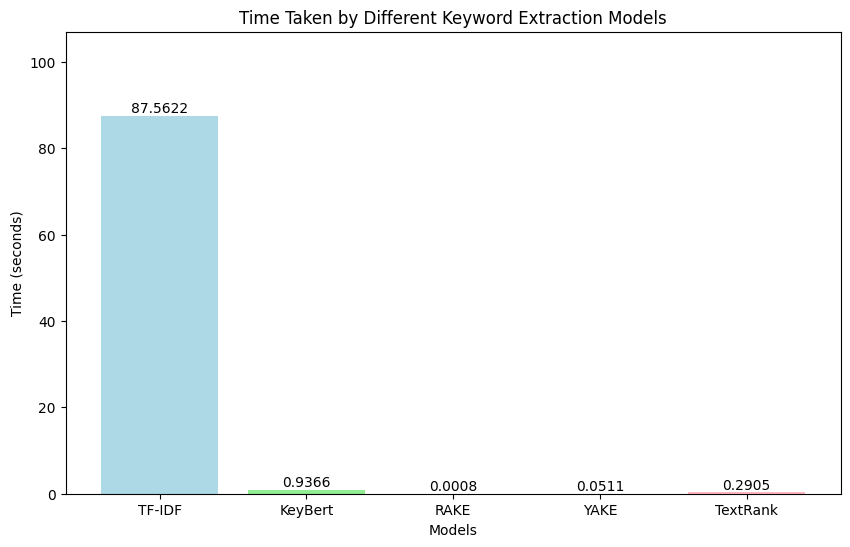

In [46]:
import matplotlib.pyplot as plt

models = list(model_time.keys())
times = [float(model_time[model]) for model in models]

# Maximum time taken among all models
max_time = max(times)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, times, color=['lightblue', 'lightgreen', 'lightcoral', 'lightgrey', 'lightpink'])
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Time Taken by Different Keyword Extraction Models')
plt.ylim(0, int(max_time) + 20)
for i in range(len(models)):
    plt.text(i, times[i] + 0.05, f"{times[i]:.4f}", ha='center', va='bottom')
plt.show()

In [35]:
#df.to_csv('nlp_paper_keywords.csv', index=False)

Model Evaluation

In [36]:
import nltk
from nltk.stem import PorterStemmer
import re
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import ndcg_score

def preprocess_and_stem(keywords):
    ps = PorterStemmer()
    preprocessed_keywords = [re.sub(r'[^\w\s]', ' ', word).lower().strip() for word in keywords]
    stemmed_keywords = [ps.stem(word) for word in preprocessed_keywords]

    return stemmed_keywords

# Function to compute relevance of keywords after stemming and comparing them
def compute_relevance(predicted_keywords, ground_truth_keywords):
    stemmed_predicted_keywords = preprocess_and_stem(predicted_keywords)
    stemmed_ground_truth_keywords = preprocess_and_stem(ground_truth_keywords)
    relevance = [1 if keyword in stemmed_ground_truth_keywords else 0 for keyword in stemmed_predicted_keywords]

    return relevance

# Function to compute evaluation metrics
def compute_metrics(predicted_keywords, ground_truth_keywords):
    relevance = compute_relevance(predicted_keywords, ground_truth_keywords)

    f1 = f1_score(relevance, [1] * len(relevance)) #harmonic mean of p&r, p->true p pred/total p pred, r -> true p pred/total actual p

    jaccard = jaccard_score(relevance, [1] * len(relevance)) #size of intersection/size of union of set

    ap = average_precision_score(relevance, range(1, len(relevance) + 1)) #for each relevant kw, compute precision of sublist till that kw, finally avg of prec scores

    nDCG = ndcg_score([relevance], [relevance]) #similar to map, but penalize highly relevant kw that appear lower in pred list

    return f1, jaccard, ap, nDCG


In [37]:
print(df.loc[0, 'author_keywords'],"\n")
print(df.loc[0, 'tf_idf_keywords'], "\n")
print(df.loc[0, 'keybert_keywords'], "\n")
print(df.loc[0, 'rake_keywords'], "\n")
print(df.loc[0, 'yake_keywords'], "\n")
print(df.loc[0, 'textrank_keywords'])

['cancer related fatigue', 'exercise', 'indirect comparison metaanalysis', 'network metaanalysis', 'nonpharmaceutical interventions'] 

['non pharmaceutical', 'exercise non', 'cancer treatment', 'cancer', 'combined'] 

['treatment yoga', 'interventions cancer', 'yoga', 'fatigue patients', 'related fatigue'] 

['usual care', 'treatment risk', 'relative effects', 'reduce crf', 'reduce crf'] 

['resistance training', 'cancer treatment', 'pharmaceutical interventions', 'non pharmaceutical', 'meta analysis'] 

['cancer treatment', 'non pharmaceutical intervention', 'cancer type', 'evaluating different type', 'different effective type']


In [38]:
# Iterate over each row in the dataframe
for index, row in df.iterrows():
    # Iterate over each model's predicted keywords
    for model in ['tf_idf', 'keybert', 'rake', 'yake', 'textrank']:
        predicted_keywords = row[model + '_keywords']
        ground_truth_keywords = row['author_keywords']

        # Compute metrics for each model
        f1, jaccard, ap, nDCG = compute_metrics(predicted_keywords, ground_truth_keywords)

        # Store the computed metrics in separate columns for each model and each metric
        df.at[index, f"{model}_f1"] = f1
        df.at[index, f"{model}_jaccard"] = jaccard
        df.at[index, f"{model}_map"] = ap
        df.at[index, f"{model}_ndcg"] = nDCG

df.head()

,title,abstract,author_keywords,title_with_abstract,tf_idf_keywords,keybert_keywords,rake_keywords,yake_keywords,textrank_keywords,tf_idf_f1,...,rake_map,rake_ndcg,yake_f1,yake_jaccard,yake_map,yake_ndcg,textrank_f1,textrank_jaccard,textrank_map,textrank_ndcg
0,Exercise and other non-pharmaceutical interven...,To assess the relative effects of different ty...,"[cancer related fatigue, exercise, indirect co...",exercise and other non pharmaceutical interven...,"[non pharmaceutical, exercise non, cancer trea...","[treatment yoga, interventions cancer, yoga, f...","[usual care, treatment risk, relative effects,...","[resistance training, cancer treatment, pharma...","[cancer treatment, non pharmaceutical interven...",0.000000,...,-0.000000,0.0,0.000000,0.0,-0.00,0.0,0.000000,0.0,-0.0,0.0
1,Effectiveness of conservative interventions in...,To investigate the effectiveness of conservati...,"[Conservative, MetaAnalysis, Pain, Shoulder Im...",effectiveness of conservative interventions in...,"[superior, shoulder impingement, manual therap...","[shoulder impingement, patients shoulder, inte...","[systematic review, shoulder impingement, shou...","[shoulder impingement, manual therapy, exercis...","[laser wa superior, tape wa superior, wa super...",0.333333,...,0.477778,1.0,0.333333,0.2,0.20,1.0,0.000000,0.0,-0.0,0.0
2,Effectiveness of myopia control interventions:...,This study aims to investigate the effectivene...,"[axial length, efficacy, elongation, myopia, p...",effectiveness of myopia control interventions ...,"[mm, atropine, myopia, dose atropine, ci]","[effectiveness myopia, control myopia, myopia ...","[systematic review, systematic review, study a...","[dose atropine, myopia progression, low dose, ...","[study treatment efficacy, reducing al progres...",0.333333,...,0.325000,1.0,0.333333,0.2,1.00,1.0,0.000000,0.0,-0.0,0.0
3,Causal relationships between gut microbiota an...,Multiple clinical studies have indicated that ...,"[PD1PDL1, bidirectional Mendelian randomizatio...",causal relationships between gut microbiota an...,"[βivw, sub fdr, fdr, sub, pd]","[microbiota pd, gut microbiota, immune checkpo...","[study aimed, positively correlated, positive ...","[sub fdr, fdr sub, sub, causal relationship, g...","[potential causal relationship, heterogeneity ...",0.000000,...,-0.000000,0.0,0.333333,0.2,1.00,1.0,0.333333,0.2,1.0,1.0
4,Prevention of hypotension after spinal anaesth...,Spinal anaesthesia for caesarean section commo...,"[anaesthesia, spinal, caesarean section, hypot...",prevention of hypotension after spinal anaesth...,"[anaesthesia, hypotension, spinal anaesthesia,...","[hypotension caesarean, anaesthesia caesarean,...","[systematic review, systematic review, spinal ...","[spinal anaesthesia, caesarean section, preven...","[trial spinal anaesthesia, trial characteristi...",0.750000,...,-0.000000,0.0,0.333333,0.2,0.25,1.0,0.000000,0.0,-0.0,0.0


In [39]:
from statistics import mean

print(mean(df['tf_idf_f1']))
print(mean(df['keybert_f1']))
print(mean(df['rake_f1']))
print(mean(df['yake_f1']))
print(mean(df['textrank_f1']))

0.20604984100373877
0.11792998842453999
0.09862424992349553
0.16833978631966898
0.08915099988025386


In [40]:
print(mean(df['tf_idf_jaccard']))
print(mean(df['keybert_jaccard']))
print(mean(df['rake_jaccard']))
print(mean(df['yake_jaccard']))
print(mean(df['textrank_jaccard']))

0.13612740989103103
0.07393126571668064
0.06806370494551552
0.11031014249790445
0.05582564962279967


In [41]:
print(mean(df['tf_idf_map']))
print(mean(df['keybert_map']))
print(mean(df['rake_map']))
print(mean(df['yake_map']))
print(mean(df['textrank_map']))

0.22225947657632486
0.13407842041538603
0.12151206109714073
0.18150321318804136
0.11743270932290212


In [42]:
print(mean(df['tf_idf_ndcg']))
print(mean(df['keybert_ndcg']))
print(mean(df['rake_ndcg']))
print(mean(df['yake_ndcg']))
print(mean(df['textrank_ndcg']))

0.4895222129086337
0.31517183570829843
0.2154233025984912
0.4098910310142498
0.24140821458507963


In [43]:
df.columns

Index(['title', 'abstract', 'author_keywords', 'title_with_abstract',
       'tf_idf_keywords', 'keybert_keywords', 'rake_keywords', 'yake_keywords',
       'textrank_keywords', 'tf_idf_f1', 'tf_idf_jaccard', 'tf_idf_map',
       'tf_idf_ndcg', 'keybert_f1', 'keybert_jaccard', 'keybert_map',
       'keybert_ndcg', 'rake_f1', 'rake_jaccard', 'rake_map', 'rake_ndcg',
       'yake_f1', 'yake_jaccard', 'yake_map', 'yake_ndcg', 'textrank_f1',
       'textrank_jaccard', 'textrank_map', 'textrank_ndcg'],
      dtype='object')

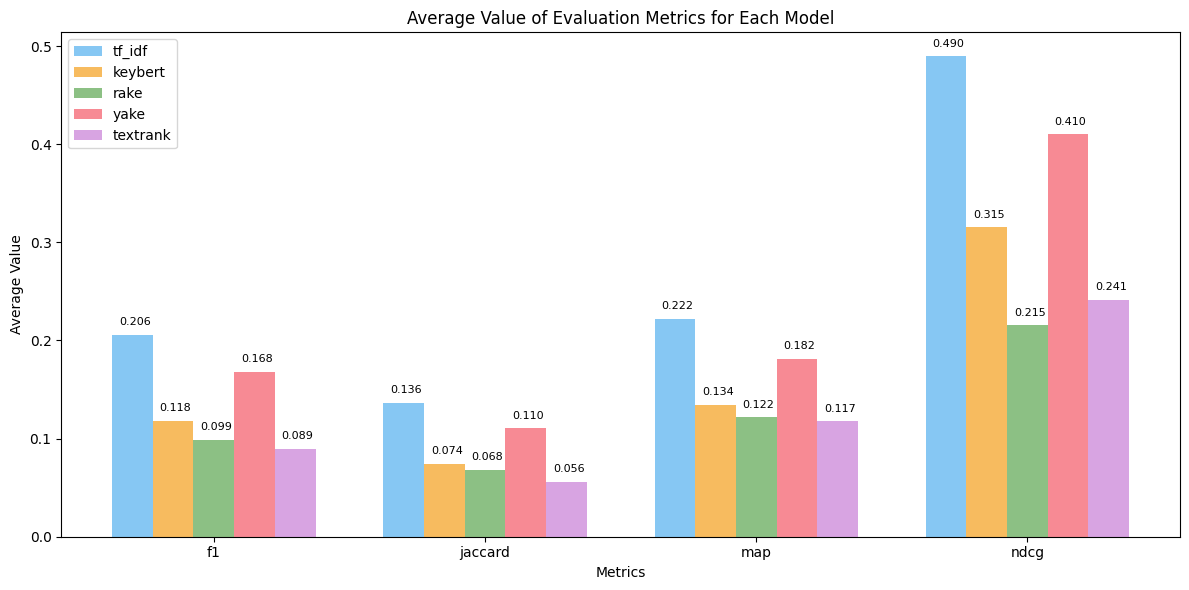

In [44]:
metric_columns = ['tf_idf_f1', 'tf_idf_jaccard', 'tf_idf_map', 'tf_idf_ndcg',
                  'keybert_f1', 'keybert_jaccard', 'keybert_map', 'keybert_ndcg',
                  'rake_f1', 'rake_jaccard', 'rake_map', 'rake_ndcg',
                  'yake_f1', 'yake_jaccard', 'yake_map', 'yake_ndcg',
                  'textrank_f1', 'textrank_jaccard', 'textrank_map', 'textrank_ndcg']

mean_values = df[metric_columns].mean()

plt.figure(figsize=(12, 6))

models = ['tf_idf', 'keybert', 'rake', 'yake', 'textrank']
metrics = ['f1', 'jaccard', 'map', 'ndcg']

colors = ['#86c7f3', '#f7bb5f', '#8cc084', '#f78a94', '#d8a4e2']

bar_width = 0.15
index = range(len(metrics))

for i, model in enumerate(models):
    model_metrics = [f'{model}_{metric}' for metric in metrics]
    model_values = mean_values[model_metrics]
    plt.bar([x + i * bar_width for x in index], model_values, bar_width, label=model, color=colors[i])

    for j, value in enumerate(model_values):
        plt.text(j + i * bar_width - 0.05, value + 0.01, f'{value:.3f}', fontsize=8, color='black')

plt.xlabel('Metrics')
plt.ylabel('Average Value')
plt.title('Average Value of Evaluation Metrics for Each Model')
plt.xticks([i + 2 * bar_width for i in index], metrics)
plt.legend()
plt.tight_layout()
plt.show()